In [1]:
import os
import cv2
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imread, imshow
from skimage import img_as_ubyte
#from catterplot import catter
context = {"font.family":'serif', "xtick.labelsize":15,
           "ytick.labelsize":15, "axes.labelsize":20, "legend.fontsize":12}

loadPics = True

In [2]:
if loadPics == True:
    files = np.sort(os.listdir('BG_removed_images/'))
    colorMap = {'BK':0, 'BW':1, 'CL':2, 'GR':3, 'GW':4, 'OG':5, 'OW':6, 'RD':7,
                'SM':8, 'TB':9, 'TS':10, 'WT':11, 'TW':12}
    df = pd.DataFrame(columns=['type', 'cat', 'lat', 'lon', 'R', 'G', 'B', 'color'])
    bad = []
    for file in files:
        cat, lat, lon = file.split('_')
        subtype = cat[0:2]
        cat = int(cat[2:])
        lat = int(lat.split('t')[1])
        lon = float(lon.split('n')[1].split('.')[0])
        #img = Image.open('BG_removed_images/'+file).convert('RGBA')
        #img = np.array(img)
        #r, g, b, a = np.rollaxis(img, axis = -1)
        image = imread('BG_removed_images/'+file)
        for channel, color in enumerate('rgb'):
            channel_values = image[:,:,channel]
            value = np.percentile(channel_values, 99)
            whitebalanced = img_as_ubyte((image*1.0 / np.percentile(image, 99, axis=(0, 1))).clip(0, 1))
        scaleR = whitebalanced[:,:,0][whitebalanced[:,:,3]!=0]
        scaleG = whitebalanced[:,:,1][whitebalanced[:,:,3]!=0]
        scaleB = whitebalanced[:,:,2][whitebalanced[:,:,3]!=0]
        Ravg = np.sqrt(np.sum(scaleR**2.)/len(scaleR))
        Gavg = np.sqrt(np.sum(scaleG**2.)/len(scaleG))
        Bavg = np.sqrt(np.sum(scaleB**2.)/len(scaleB))
        df = df.append({'type':subtype, 'cat':cat, 'lat':lat, 'lon':lon,
                        'R':Ravg, 'G':Gavg, 'B':Bavg, 'color':colorMap[subtype]}, ignore_index=True)
        if np.abs(lon) == 180:
            df = df.append({'type':subtype, 'cat':cat, 'lat':lat, 'lon':-lon,
                        'R':Ravg, 'G':Gavg, 'B':Bavg, 'color':colorMap[subtype]}, ignore_index=True)
    print(df)
    df.to_csv('catpd.csv', index=False)
else:
    df = pd.read_csv('catpd.csv')

    type cat lat    lon           R           G           B color
0     BK   3   0    0.0   62.082007   68.832964   69.339605     0
1     BK   4   0 -135.0   54.041736   54.076329   51.556709     0
2     BK   4   0    0.0   72.016139   67.309565   62.792369     0
3     BK   4   0  135.0   76.856639   73.570151   71.756605     0
4     BK   5   0  -45.0   63.186438   62.601432   61.174272     0
..   ...  ..  ..    ...         ...         ...         ...   ...
385   WT   6   0  135.0  191.423623  205.704841  204.553566    11
386   WT   6   0  180.0  162.755784  159.579721  154.968404    11
387   WT   6   0 -180.0  162.755784  159.579721  154.968404    11
388   WT   6   0   45.0  210.716230  209.702048  208.073624    11
389   WT   6   0   90.0  185.552084  168.213735  151.566640    11

[390 rows x 8 columns]


BK [1 2 2 1 7 3 2 1 1]
BW [ 4  5  6 11 14  5  5  6  4]
CL [ 8  4  5  6 17  9  6  6  8]
GR [0 1 1 0 1 1 1 0 0]
GW [6 1 1 1 9 4 3 1 6]
OG [2 1 2 1 5 0 2 1 2]
OW [1 2 2 2 8 0 4 2 1]
RD [1 0 0 0 1 0 0 0 1]
SM [0 0 1 0 1 0 0 0 0]
TB [ 7  3  9  7 21  6  6  7  7]
TS [3 0 2 3 6 2 1 0 3]
TW [ 5  2  6  1 14  7  6  2  5]
WT [2 1 2 2 5 3 2 1 2]


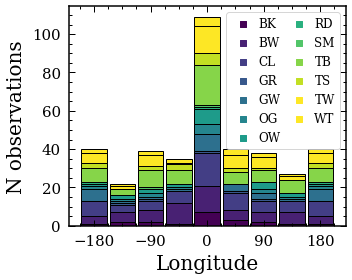

In [15]:
with matplotlib.rc_context(context):
    plt.figure(figsize=(5,4))
    colors = []
    for subtype in np.unique(df['type']):
        color = plt.cm.viridis(df['color'][df['type']==subtype].iloc[0]/11)
        colors.append(color)
        n,_ = np.histogram(df['lon'][df['type']==subtype], bins=np.arange(-180-45/2,180+45/2+1,45))
        print(subtype, n)
        plt.scatter([],[], marker='s', color=color, label=f"{subtype}")
    plt.hist([df['lon'][df['type']==subtype] for subtype in np.unique(df['type'])], 
             bins=np.arange(-180-45/2,180+45/2+1,45), stacked=True, rwidth=0.9, 
             color=colors, edgecolor='k', align='mid')
    plt.legend(ncol=2, columnspacing=0.5, handletextpad=0.3)
    plt.ylabel('N observations')
    plt.xlabel('Longitude')
    plt.xticks(np.arange(-180,181,90))
    plt.tight_layout()
    plt.savefig('obs_hist.png', format='png', bbox_to_inches='tight')
    plt.show()

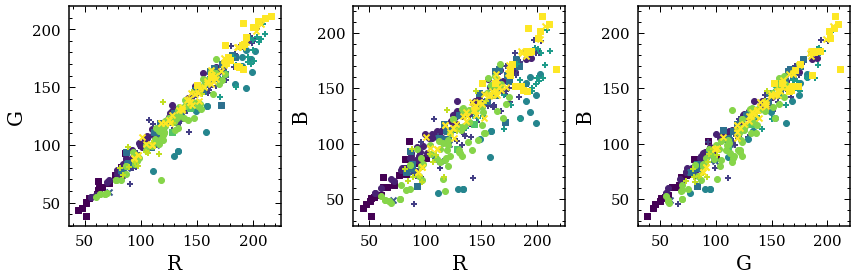

In [17]:
with matplotlib.rc_context(context):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    symbols = ['s', 'o', '+', 'x']
    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[0].scatter(df['R'][df['type']==subtype], df['G'][df['type']==subtype], 
                      color=color, marker=symbols[i%4])
    ax[0].set_xlabel('R')
    ax[0].set_ylabel('G')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[1].scatter(df['R'][df['type']==subtype], df['B'][df['type']==subtype], 
                      color=color, marker=symbols[i%4])
    ax[1].set_xlabel('R')
    ax[1].set_ylabel('B')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[2].scatter(df['G'][df['type']==subtype], df['B'][df['type']==subtype], 
                      color=color, marker=symbols[i%4])
    ax[2].set_xlabel('G')
    ax[2].set_ylabel('B')
    plt.tight_layout()
    plt.show()

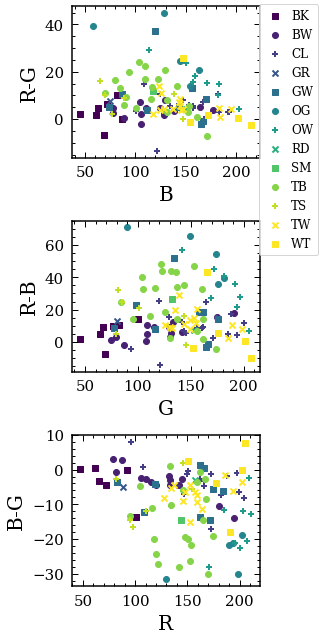

In [46]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    fig, ax = plt.subplots(3,1, figsize=(4.5,9))
    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[0].scatter(df['B'][(df['type']==subtype) & (df['lon']==0)],
                      df['R'][(df['type']==subtype) & (df['lon']==0)]-
                      df['G'][(df['type']==subtype) & (df['lon']==0)], 
                      color=color, marker=symbols[i%4], label=subtype)
    ax[0].set_ylabel('R-G')
    ax[0].set_xlabel('B')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[1].scatter(df['G'][(df['type']==subtype) & (df['lon']==0)],
                      df['R'][(df['type']==subtype) & (df['lon']==0)]-
                      df['B'][(df['type']==subtype) & (df['lon']==0)], 
                      color=color, marker=symbols[i%4])
    ax[1].set_ylabel('R-B')
    ax[1].set_xlabel('G')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[2].scatter(df['R'][(df['type']==subtype) & (df['lon']==0)], 
                      df['B'][(df['type']==subtype) & (df['lon']==0)]-
                      df['G'][(df['type']==subtype) & (df['lon']==0)], 
                      color=color, marker=symbols[i%4])
    ax[2].set_ylabel('B-G')
    ax[2].set_xlabel('R')
    plt.tight_layout()
    plt.subplots_adjust(left=0.2,right=0.78)
    fig.legend(bbox_to_anchor=[1,0.99], loc='upper right', handletextpad=0.3)

    plt.savefig('color_mag.png', format='png', bbox_to_inches='tight')
    plt.show()
    #color color of single category and viewing geometry

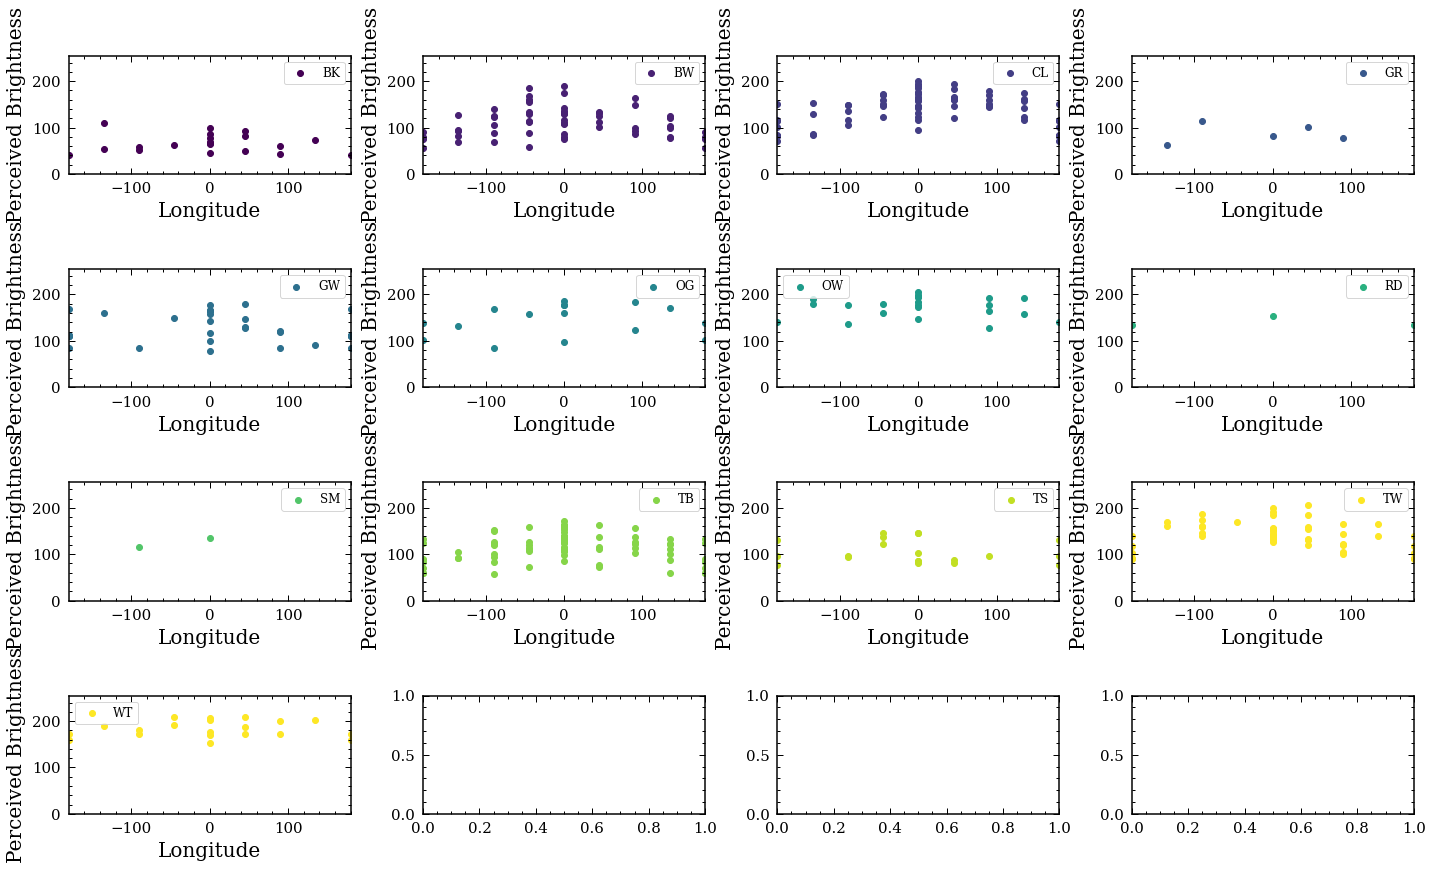

In [48]:
with matplotlib.rc_context(context):
    fig, ax = plt.subplots(4,4, figsize=(20,12))
    axes = ax.flatten()
    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        avgbright = 0.299*(df['R'][df['type']==subtype]) + \
        0.587*(df['G'][df['type']==subtype]) + \
        0.114*(df['B'][df['type']==subtype])
        #(0.299*R + 0.587*G + 0.114*B), https://www.w3.org/TR/AERT/#color-contrast
        axes[i].scatter(df['lon'][df['type']==subtype], avgbright, color=color, label=subtype)
        axes[i].set_ylim(0,255)
        axes[i].set_xlim(-180,180)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Perceived Brightness')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

BW: 1 15 23 
CL: 1 3 4 5 7 19 23 
GR: 2 
GW: 2 10 16 
OG: 1 3 
OW: 11 
TB: 13 26 28 29 41 47 48 
TS: 3 
TW: 18 21 23 32 46 
WT: 5 6 


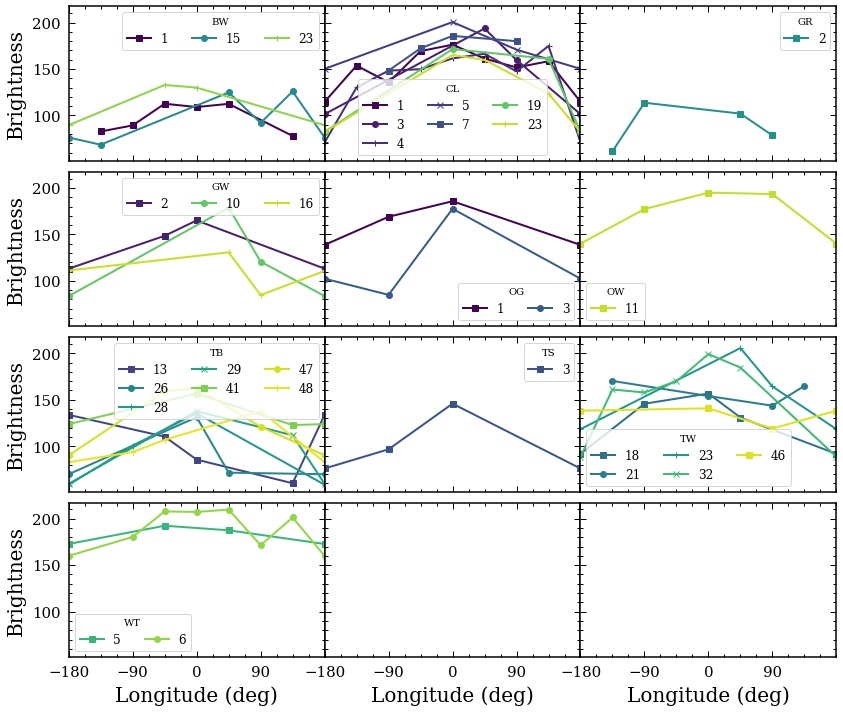

In [49]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    types = []
    for subtype in np.unique(df['type']):
        for cat in np.unique(df['cat'][df['type']==subtype]):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                types.append(subtype)
    types = np.unique(types)
    fig, axes = plt.subplots(int(np.ceil(len(types)/3.)), 3, figsize=(12,len(types)), sharey=True, sharex=True)
    ax = axes.flatten()
    for i,subtype in enumerate(types):
        color = plt.cm.viridis(df['color'][df['type']==subtype].iloc[0]/11)
        string = subtype + ': '
        count = 0
        for j,cat in enumerate(np.unique(df['cat'][df['type']==subtype])):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                index = df['cat'].loc[(df['type']==subtype) & (df['cat'] == cat)].index
                sortindex = np.argsort(df['lon'][index])
                avgbright = 0.299*(df['R'][index[sortindex]]) + \
                    0.587*(df['G'][index[sortindex]]) + \
                    0.114*(df['B'][index[sortindex]])
                ax[i].plot(df['lon'][index[sortindex]], avgbright, 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                string += f"{cat} "
                count += 1
        print(string)
        ax[i].legend(ncol=3, title=subtype)
    for ax in axes[:,0]:
        ax.set_ylabel('Brightness')
    axes[0,0].set_xlim(-180,180)
    axes[0,0].set_xticks(np.arange(-180,180,90))
    axes[-1,0].set_xlabel('Longitude (deg)')
    axes[-1,1].set_xlabel('Longitude (deg)')
    axes[-1,2].set_xlabel('Longitude (deg)')
    #axes[0,0].set_ylim(0,255)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

BW: 1 15 23 
CL: 1 3 4 5 7 19 23 
GR: 2 
GW: 2 10 16 
OG: 1 3 
OW: 11 
TB: 13 26 28 29 41 47 48 
TS: 3 
TW: 18 21 23 32 46 
WT: 5 6 


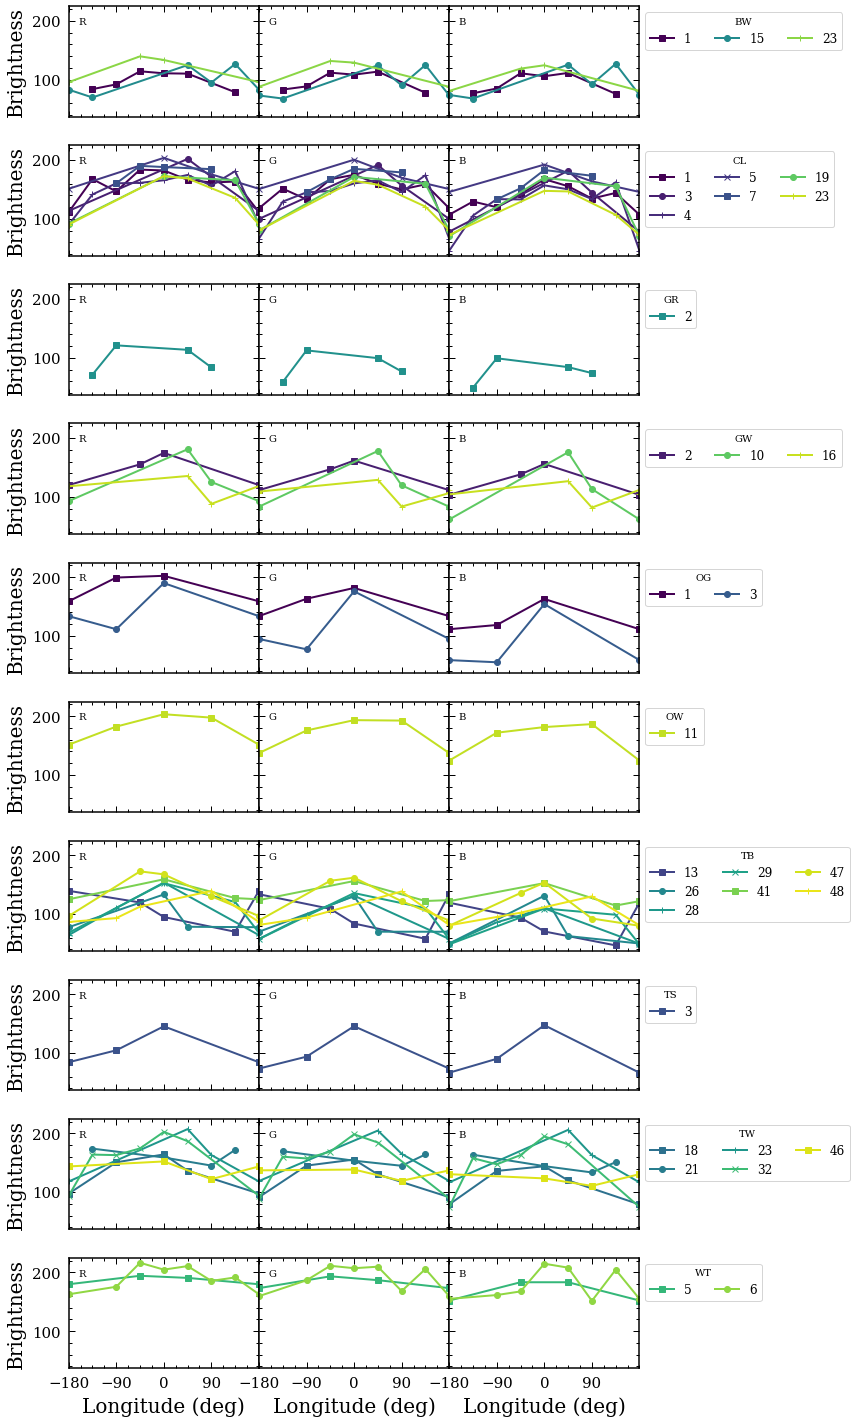

In [50]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    types = []
    for subtype in np.unique(df['type']):
        for cat in np.unique(df['cat'][df['type']==subtype]):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                types.append(subtype)
    types = np.unique(types)
    fig, axes = plt.subplots(len(types),3, figsize=(12,len(types)*2), sharey=True, sharex=True)
    for i,subtype in enumerate(types):
        color = plt.cm.viridis(df['color'][df['type']==subtype].iloc[0]/11)
        string = subtype + ': '
        count = 0
        for j,cat in enumerate(np.unique(df['cat'][df['type']==subtype])):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                index = df['cat'].loc[(df['type']==subtype) & (df['cat'] == cat)].index
                sortindex = np.argsort(df['lon'][index])
                axes[i,0].plot(df['lon'][index[sortindex]], df['R'][index[sortindex]], 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                axes[i,1].plot(df['lon'][index[sortindex]], df['G'][index[sortindex]], 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                axes[i,2].plot(df['lon'][index[sortindex]], df['B'][index[sortindex]], 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                string += f"{cat} "
                count += 1
        print(string)
        axes[i,0].text(0.05,0.9, 'R', va='top', ha='left', transform=axes[i,0].transAxes)
        axes[i,1].text(0.05,0.9, 'G', va='top', ha='left', transform=axes[i,1].transAxes)
        axes[i,2].text(0.05,0.9, 'B', va='top', ha='left', transform=axes[i,2].transAxes)
        axes[i,0].set_ylabel('Brightness')
        axes[i,2].legend(bbox_to_anchor=[1,1], ncol=3, title=subtype, loc='upper left')
    axes[0,0].set_xlim(-180,180)
    axes[0,0].set_xticks(np.arange(-180,180,90))
    axes[-1,0].set_xlabel('Longitude (deg)')
    axes[-1,1].set_xlabel('Longitude (deg)')
    axes[-1,2].set_xlabel('Longitude (deg)')
    #axes[0,0].set_ylim(0,255)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()